# Test Quantization

In [1]:
from common import Params, FromParams, load_configs
from quantization import Quantizer
import torch
import json
import matplotlib.pyplot as plt

## Normal

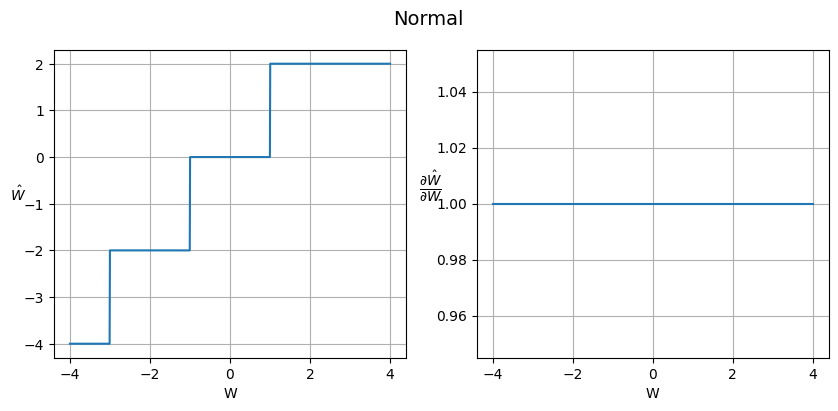

In [4]:
param_str = """{"N_bits": 2, "signed":1, "p0": 0.0, "type": "normal"}"""
params = Params(json.loads(param_str))
q_module = Quantizer.from_params(params)

weight = torch.linspace(-4., 4., 1000).requires_grad_(True)
weight_quan = q_module(weight)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Normal", fontsize=14)
ax1.plot(weight.detach(), weight_quan.detach())
ax1.set_xlabel("W")
ax1.set_ylabel(r"$\hat{W}$", rotation=0)
ax1.grid()

dwhat_dw = torch.autograd.grad(weight_quan.sum(), weight)[0]
ax2.plot(weight.detach(), dwhat_dw.detach())
ax2.set_xlabel("W")
ax2.set_ylabel(r"$\frac{\partial \hat{W}}{\partial W}$", rotation=0, fontsize=14)
ax2.grid()


## Wclip

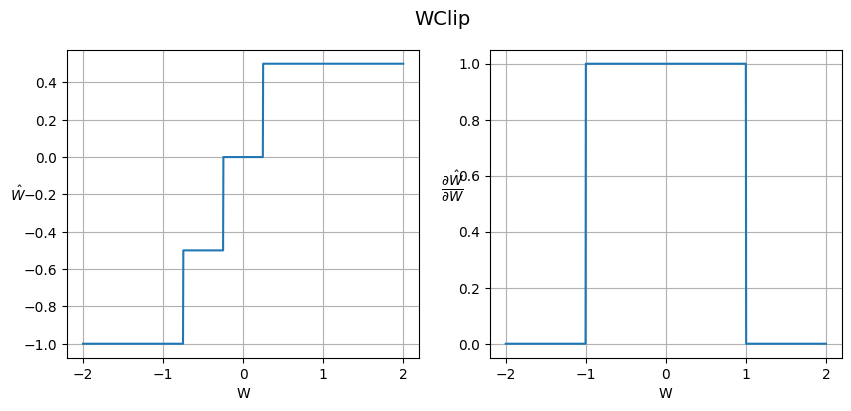

In [22]:
param_str = """{"N_bits": 2, "signed": 1, "p0": 0.0, "type": "wclip", "wclip": 1.0}"""
params = Params(json.loads(param_str))
q_module = Quantizer.from_params(params)

weight = torch.linspace(-2., 2, 1000).requires_grad_(True)
weight_quan = q_module(weight)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("WClip", fontsize=14)
ax1.plot(weight.detach(), weight_quan.detach())
ax1.set_xlabel("W")
ax1.set_ylabel(r"$\hat{W}$", rotation=0)
ax1.grid()

dwhat_dw = torch.autograd.grad(weight_quan.sum(), weight)[0]
ax2.plot(weight.detach(), dwhat_dw.detach())
ax2.set_xlabel("W")
ax2.set_ylabel(r"$\frac{\partial \hat{W}}{\partial W}$", rotation=0, fontsize=14)
ax2.grid()


## Plclip

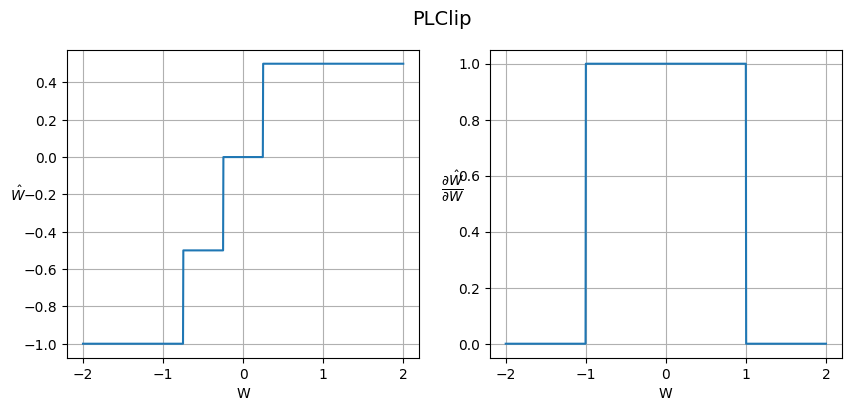

In [25]:
param_str = """{"N_bits": 2, "signed": 1, "p0": 0.0, "type": "plclip", "plclip": 1.0}"""
params = Params(json.loads(param_str))
q_module = Quantizer.from_params(params)

weight = torch.linspace(-2., 2, 1000).requires_grad_(True)
weight_quan = q_module(weight)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("PLClip", fontsize=14)
ax1.plot(weight.detach(), weight_quan.detach())
ax1.set_xlabel("W")
ax1.set_ylabel(r"$\hat{W}$", rotation=0)
ax1.grid()

dwhat_dw = torch.autograd.grad(weight_quan.sum(), weight)[0]
ax2.plot(weight.detach(), dwhat_dw.detach())
ax2.set_xlabel("W")
ax2.set_ylabel(r"$\frac{\partial \hat{W}}{\partial W}$", rotation=0, fontsize=14)
ax2.grid()


## LSQ

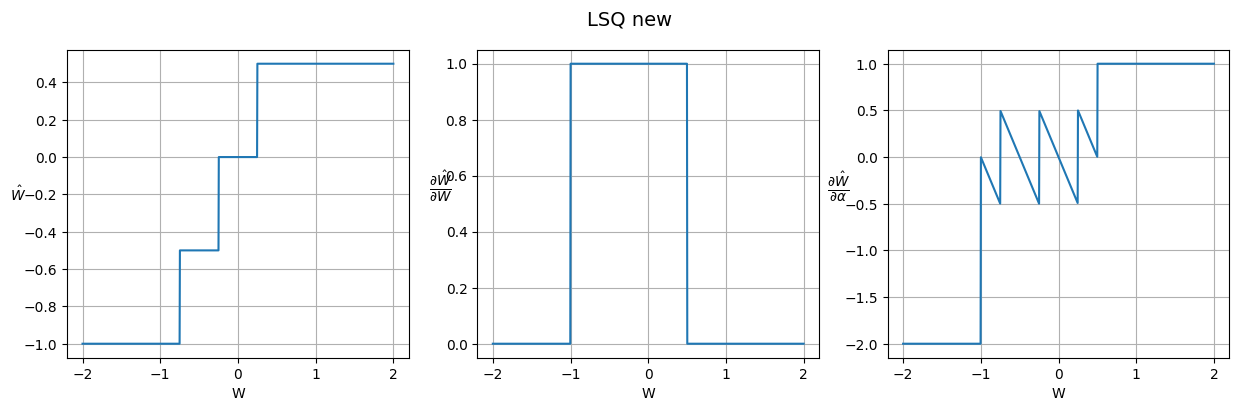

In [26]:
param_str = """{"N_bits": 2, "signed":1, "p0": 0.0, "type": "lsq","use_grad_scaled": 1}"""
params = Params(json.loads(param_str))
q_module = Quantizer.from_params(params)
q_module.step_size.data = torch.tensor(0.5)

weight = torch.linspace(-2., 2, 1000).requires_grad_(True)
weight_quan = q_module(weight)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("LSQ new", fontsize=14)
ax1.plot(weight.detach(), weight_quan.detach())
ax1.set_xlabel("W")
ax1.set_ylabel(r"$\hat{W}$", rotation=0)
ax1.grid()

dwhat_dw = torch.autograd.grad(weight_quan.sum(), weight)[0]
ax2.plot(weight.detach(), dwhat_dw.detach())
ax2.set_xlabel("W")
ax2.set_ylabel(r"$\frac{\partial \hat{W}}{\partial W}$", rotation=0, fontsize=14)
ax2.grid()

dwhat_ds = []
for i in range(len(weight)):
    weight_quan = q_module(weight[i])
    dwhat_ds.append(torch.autograd.grad(weight_quan, q_module.step_size)[0])
ax3.plot(weight.detach(), torch.tensor(dwhat_ds).detach())
ax3.set_xlabel("W")
ax3.set_ylabel(r"$\frac{\partial \hat{W}}{\partial \alpha}$", rotation=0, fontsize=14)
ax3.grid()

## WCAT

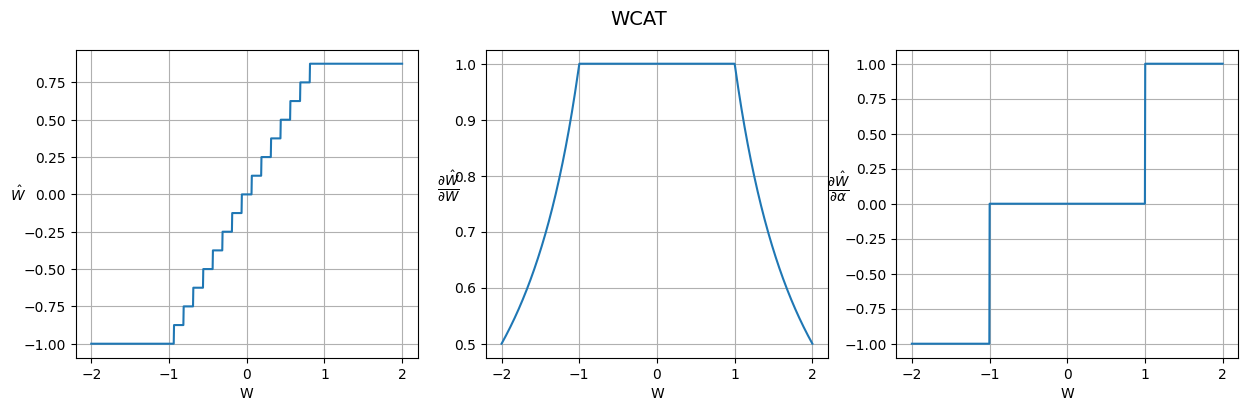

In [38]:
param_str = """{"N_bits": 4, "signed":1, "p0": 0.0, "type": "wcat", "use_grad_scaled": 1, "clip":{"type": "mad"}}"""
params = Params(json.loads(param_str))
q_module = Quantizer.from_params(params)
q_module.q_range.data = torch.tensor(1.0)

weight = torch.linspace(-2., 2, 1000).requires_grad_(True)
weight_quan = q_module(weight)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("WCAT", fontsize=14)
ax1.plot(weight.detach(), weight_quan.detach())
ax1.set_xlabel("W")
ax1.set_ylabel(r"$\hat{W}$", rotation=0)
ax1.grid()

dwhat_dw = torch.autograd.grad(weight_quan.sum(), weight)[0]
ax2.plot(weight.detach(), dwhat_dw.detach())
ax2.set_xlabel("W")
ax2.set_ylabel(r"$\frac{\partial \hat{W}}{\partial W}$", rotation=0, fontsize=14)
ax2.grid()

dwhat_ds = []
for i in range(len(weight)):
    weight_quan = q_module(weight[i])
    dwhat_ds.append(torch.autograd.grad(weight_quan, q_module.q_range)[0])
ax3.plot(weight.detach(), torch.tensor(dwhat_ds).detach())
ax3.set_xlabel("W")
ax3.set_ylabel(r"$\frac{\partial \hat{W}}{\partial \alpha}$", rotation=0, fontsize=14)
ax3.grid()

In [5]:
from models import Base_Model
from data import Dataset
from train import evaluate
from common import Params, FromParams, load_configs, creat_unique_experiment_name
from quantization import Quantizer
from runtime import Runtime
import torch
import json
import copy
import matplotlib.pyplot as plt

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


/Users/kmchiti/PycharmProjects/WCAT_pre/ENV/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [40]:
import torch.nn.functional as F

_config = load_configs('../configs/example.jsonnet')
exp_name = creat_unique_experiment_name(_config)
_config_copy = copy.deepcopy(_config)
experiment = Runtime.from_params(Params(_config))
experiment.setup(exp_name, _config_copy)
images = torch.randn(1,3,32,32)
model = experiment.model
device = experiment.model.device



m = model.conv1
weight_quant = m.weight_quantize_module(m.weight)
y = F.conv2d(images, weight_quant, m.bias, m.stride, m.padding, m.dilation, m.groups)
print("data:", images.reshape(-1)[:5])
print("weight:", weight_quant.reshape(-1)[:5].data)
print("output:", y.reshape(-1)[:5].data)

data: tensor([-0.1800, -0.4012,  1.7354,  0.5755, -0.6588])
weight: tensor([ 0.1116,  0.0000,  0.1488,  0.0744, -0.0744])
output: tensor([ 0.2194, -0.2742,  0.1609,  0.5656,  0.3964])


In [38]:
labels

tensor([8, 2, 7, 3, 9, 2, 7, 8, 7, 4, 9, 4, 6, 6, 2, 0, 4, 0, 8, 2, 4, 0, 6, 4,
        6, 8, 1, 3, 3, 6, 4, 0, 1, 4, 6, 8, 5, 7, 4, 3, 5, 4, 2, 7, 1, 4, 0, 4,
        1, 9, 9, 3, 6, 4, 4, 5, 6, 1, 8, 2, 2, 0, 8, 9, 2, 5, 2, 6, 4, 0, 8, 4,
        4, 3, 8, 7, 5, 0, 5, 4, 6, 1, 9, 9, 5, 7, 6, 6, 5, 7, 7, 9, 2, 2, 2, 5,
        7, 7, 4, 8, 7, 5, 8, 0, 6, 5, 0, 1, 7, 2, 2, 1, 0, 5, 1, 6, 9, 7, 8, 5,
        2, 7, 4, 0, 2, 3, 4, 7, 1, 1, 2, 4, 9, 0, 4, 0, 1, 8, 9, 0, 5, 1, 6, 5,
        4, 1, 5, 3, 7, 6, 8, 9, 3, 6, 6, 9, 6, 2, 0, 6, 0, 5, 9, 6, 7, 5, 9, 1,
        9, 2, 4, 9, 2, 3, 9, 2, 7, 2, 8, 4, 4, 8, 9, 9, 3, 6, 1, 6, 8, 0, 6, 9,
        3, 8, 9, 6, 3, 0, 4, 0, 7, 6, 9, 6, 6, 1, 9, 0, 2, 9, 2, 5, 3, 0, 5, 9,
        6, 9, 2, 7, 4, 3, 4, 7, 5, 0, 7, 9, 1, 6, 9, 6, 5, 6, 3, 8, 6, 1, 8, 7,
        9, 6, 6, 7, 4, 6, 3, 2, 5, 9, 7, 7, 8, 7, 8, 9])

In [16]:
m = model.conv1
weight_quant = m.weight_quantize_module(m.weight)
print(m.weight.reshape(-1)[:5].data)
print(weight_quant.reshape(-1)[:5].data)

print(m.weight.reshape(-1)[123].item(), weight_quant.reshape(-1)[123].item())

tensor([ 0.0959,  0.0118,  0.1630,  0.0589, -0.0737])
tensor([ 0.1116,  0.0000,  0.1488,  0.0744, -0.0744])
-0.11177181452512741 -0.11161099374294281


In [28]:
import torch.nn.functional as F
y = F.conv2d(x, weight_quant, m.bias, m.stride, m.padding, m.dilation, m.groups)
print("data:", x.reshape(-1)[:5])
print("weight:", weight_quant.reshape(-1)[:5].data)
print("output:", y.reshape(-1)[:5].data)

data: tensor([-0.1800, -0.4012,  1.7354,  0.5755, -0.6588])
weight: tensor([ 0.1116,  0.0000,  0.1488,  0.0744, -0.0744])
output: tensor([ 0.2194, -0.2742,  0.1609,  0.5656,  0.3964])


In [21]:
m.stride, m.padding, m.dilation, m.groups, m.bias, m.weight.shape

((1, 1), (1, 1), (1, 1), 1, None, torch.Size([16, 3, 3, 3]))

In [7]:

_config = load_configs('../configs/example.jsonnet')
exp_name = creat_unique_experiment_name(_config)
_config_copy = copy.deepcopy(_config)
experiment = Runtime.from_params(Params(_config))
experiment.setup(exp_name, _config_copy)
model = experiment.model
device = experiment.model.device
# model.train()
# x = torch.randn(32, 3, 32, 32)
# y = model(x)
# print(y[13][3].item())


experiment.trainer.build(model)
train_loader, test_loader, valid_loader, calibration_loader = experiment.dataset.build()

model.train()
for i, (images, labels) in enumerate(train_loader):
    if i>=1:
        break
    output = model.modified_forward(images.to(model.device))  # TODO: on_blocking=True ?
    output = model(images.to(device))
    loss = experiment.trainer.criterion(output, labels.to(device))
    prec1 = accuracy(output.data, labels.to(device))
    experiment.trainer.optimizer.zero_grad()
    loss.backward()
    print(f"iter{i}: loss={loss.item()}, acc={prec1}")
    #experiment.trainer.optimizer.step()


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/Users/kmchiti/PycharmProjects/WCAT_pre/ENV/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kmchiti/PycharmProjects/WCAT_pre/ENV/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kmchiti/PycharmProjects/WCAT_pre/ENV/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kmchiti/PycharmProjects/WCAT_pre/ENV/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only 

iter0: loss=2.341372013092041, acc=[tensor(13.6719)]


In [19]:
model.conv1.weight_quantize_module.step_size

tensor(0.0372)

In [25]:
m = model.fc
weight_quant = m.weight_quantize_module(m.weight)
weight_quant.reshape(-1)[:10]

tensor([-0.1091, -0.0468, -0.0935, -0.1091, -0.0312,  0.1091, -0.0468, -0.0935,
        -0.0312,  0.0935], grad_fn=<SliceBackward0>)

In [24]:
m.weight.grad.reshape(-1)[:10]

tensor([ 0.0294,  0.0301, -0.0090,  0.0173,  0.0091, -0.0260, -0.0069, -0.0148,
        -0.0322,  0.0331])